# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

**TP completed by Nil-Dany MOSTEFAI**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu118.html
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [60 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-3.10
      creating build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/placeholder.py -> build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/segment_coo.py -> build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/segment_csr.py -> build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/testing.py -> build/lib.linux-x86_64-3.10/torch_scatter
      copying torch_scatter/utils.py -> 

In [2]:
! pip install torch_geometric

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [1]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node). 

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [2]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [3]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [14]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [117]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):

            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [8]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6366
F1-Score: 0.4534
Epoch 00002 | Loss: 0.5800
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5548
Epoch 00005 | Loss: 0.5504
Epoch 00006 | Loss: 0.5455
F1-Score: 0.5153
Epoch 00007 | Loss: 0.5419
Epoch 00008 | Loss: 0.5380
Epoch 00009 | Loss: 0.5341
Epoch 00010 | Loss: 0.5310
Epoch 00011 | Loss: 0.5283
F1-Score: 0.5148
Epoch 00012 | Loss: 0.5257
Epoch 00013 | Loss: 0.5232
Epoch 00014 | Loss: 0.5209
Epoch 00015 | Loss: 0.5186
Epoch 00016 | Loss: 0.5163
F1-Score: 0.5337
Epoch 00017 | Loss: 0.5140
Epoch 00018 | Loss: 0.5118
Epoch 00019 | Loss: 0.5096
Epoch 00020 | Loss: 0.5076
Epoch 00021 | Loss: 0.5055
F1-Score: 0.5466
Epoch 00022 | Loss: 0.5035
Epoch 00023 | Loss: 0.5016
Epoch 00024 | Loss: 0.4998
Epoch 00025 | Loss: 0.4982
Epoch 00026 | Loss: 0.4969
F1-Score: 0.5551
Epoch 00027 | Loss: 0.4959
Epoch 00028 | Loss: 0.4956
Epoch 00029 | Loss: 0.4958
Epoch 00030 | Loss: 0.4940
Epoch 00031 | Loss: 0.4914
F1-Score: 0.5402
Epoch 00032 | Loss: 0.4891
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6541


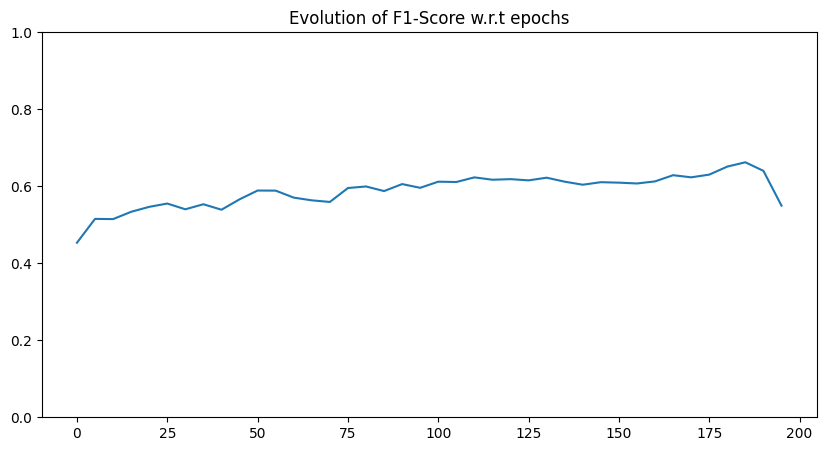

In [9]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files : 
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights
 
 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.
 
Intermediate question : 

 Provide the script for training, and a plot of the training loss.  

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model ( in your class_model_gnn.py)
class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_heads = 4):
        super(StudentModel, self).__init__()

        self.gatconv1 = graphnn.GATConv(input_size, hidden_size, heads = n_heads, concat = True)
        self.gatconv2 = graphnn.GATConv(hidden_size * n_heads, hidden_size, heads = n_heads, concat = True)
        
        self.gatconv3 = graphnn.GATConv(hidden_size* n_heads , output_size, heads = 6, concat = False)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, edge_index):
        x1 = self.elu(self.gatconv1(x, edge_index))
        x2= self.elu(self.gatconv2(x1, edge_index))
        #x2 = torch.concat((x1, x2),dim = -1)
        x3= self.gatconv3(x2, edge_index)
        #x4= self.gatconv4(x3, edge_index)
        return x3



model = StudentModel(50, 256, 121)
model(train_dataset[0].x, train_dataset[0].edge_index).shape

torch.Size([1767, 121])

In [281]:
# I didn't use this function, use if you want a more finegrained training.
def train_gat(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader, milestones, gamma = 0.5, ):
    epoch_list = []
    scores_list = []
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = milestones, gamma = gamma,)
    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):

            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        scheduler.step()
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))
        
        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)
            if score > 0.93:
                break
    return epoch_list, scores_list

In [62]:
max_epochs = 200

### DEFINE THE MODEL
model = StudentModel(n_features, 256, n_classes).to(device)


### DEFINE LOSS FUNCTION
loss_fcn = nn.BCELossWithLogits()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)

Epoch 00001 | Loss: 0.6662
F1-Score: 0.4027
Epoch 00002 | Loss: 0.5652
Epoch 00003 | Loss: 0.5387
Epoch 00004 | Loss: 0.5223
Epoch 00005 | Loss: 0.5132
Epoch 00006 | Loss: 0.5056
F1-Score: 0.5071
Epoch 00007 | Loss: 0.4972
Epoch 00008 | Loss: 0.4895
Epoch 00009 | Loss: 0.4831
Epoch 00010 | Loss: 0.4738
Epoch 00011 | Loss: 0.4698
F1-Score: 0.5757
Epoch 00012 | Loss: 0.4683
Epoch 00013 | Loss: 0.4584
Epoch 00014 | Loss: 0.4520
Epoch 00015 | Loss: 0.4477
Epoch 00016 | Loss: 0.4468
F1-Score: 0.6134
Epoch 00017 | Loss: 0.4424
Epoch 00018 | Loss: 0.4394
Epoch 00019 | Loss: 0.4290
Epoch 00020 | Loss: 0.4236
Epoch 00021 | Loss: 0.4172
F1-Score: 0.6246
Epoch 00022 | Loss: 0.4146
Epoch 00023 | Loss: 0.4061
Epoch 00024 | Loss: 0.4002
Epoch 00025 | Loss: 0.3947
Epoch 00026 | Loss: 0.3890
F1-Score: 0.6590
Epoch 00027 | Loss: 0.3934
Epoch 00028 | Loss: 0.3969
Epoch 00029 | Loss: 0.3838
Epoch 00030 | Loss: 0.3747
Epoch 00031 | Loss: 0.3651
F1-Score: 0.6854
Epoch 00032 | Loss: 0.3598
Epoch 00033 | Los

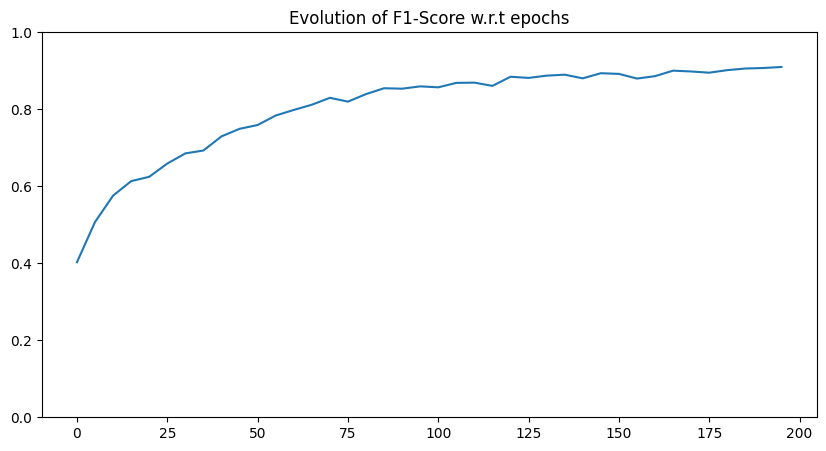

In [63]:
plot_f1_score(epoch_list, model_scores)

**The model starts to really overfit at around epoch 180. Now I will try to retrain this model with a smaller learning rate. I can't add dropout now, otherwise it will reset the parameters of the model.**

In [65]:
score_valid = evaluate(model, loss_fcn, device, val_dataloader)
print("My model : F1-Score on the validation set: {:.4f}".format(score_valid))

My model : F1-Score on the validation set: 0.9056


In [70]:
torch.save(model.state_dict(), "Model_90F1.pth")

In [71]:
weights = torch.load("Model_90F1.pth", weights_only = True)

In [249]:
model_to_finetune = StudentModel(n_features, 256, n_classes).to(device)
model_to_finetune.load_state_dict(torch.load('Model_90F1.pth'))


<All keys matched successfully>

In [250]:
score_valid = evaluate(model_to_finetune, loss_fcn, device, val_dataloader)
print("Loaded model : F1-Score on the validation set: {:.4f}".format(score_valid))

Loaded model : F1-Score on the validation set: 0.9056


In [251]:
max_epochs = 20



### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(model_to_finetune.parameters(), lr=0.0007,) 

### TRAIN THE MODEL
epoch_list, model_scores_finetuned = train(
    model_to_finetune,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)

Epoch 00001 | Loss: 0.0555
F1-Score: 0.9171
Epoch 00002 | Loss: 0.0458
Epoch 00003 | Loss: 0.0400
Epoch 00004 | Loss: 0.0370
Epoch 00005 | Loss: 0.0352
Epoch 00006 | Loss: 0.0340
F1-Score: 0.9252
Epoch 00007 | Loss: 0.0331
Epoch 00008 | Loss: 0.0322
Epoch 00009 | Loss: 0.0316
Epoch 00010 | Loss: 0.0311
Epoch 00011 | Loss: 0.0309
F1-Score: 0.9256
Epoch 00012 | Loss: 0.0309
Epoch 00013 | Loss: 0.0305
Epoch 00014 | Loss: 0.0305
Epoch 00015 | Loss: 0.0298
Epoch 00016 | Loss: 0.0299
F1-Score: 0.9227
Epoch 00017 | Loss: 0.0300
Epoch 00018 | Loss: 0.0301
Epoch 00019 | Loss: 0.0301
Epoch 00020 | Loss: 0.0313


In [252]:
score_valid = evaluate(model_to_finetune, loss_fcn, device, val_dataloader)
print("Loaded model : F1-Score on the validation set: {:.4f}".format(score_valid))

Loaded model : F1-Score on the validation set: 0.9225


In [11]:
torch.save(model_to_finetune.state_dict(), "model.pth")

In [12]:
model_to_finetune = StudentModel(n_features, 256, n_classes).to(device)
model_to_finetune.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [17]:
score_valid = evaluate(model_to_finetune, loss_fcn, device, val_dataloader)
print("Loaded model : F1-Score on the validation set: {:.4f}".format(score_valid))

Loaded model : F1-Score on the validation set: 0.9225


**The model reaches 92.37 %, which is pretty good. An improvement would be to mimic exactly what has been implemented in the paper. However, I found that adding residual connections make the model learn slowly (the loss slighly decreases at each epoch), and I don't have infinite time so I will give you this model.**

## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ : 

$$ \gamma_\Theta : x,y \mapsto y $$


**Anwser 2**

Given an image $u$ of shape $(C, H, W)$:
* Preprocess : We convert $u$ into a graph $\hat{u} = (V, E)$ where each node corresponds to a pixel, and two nodes are linked together if they are neighbors in the image given the kernel size.

So $x \in V$ is a feature vector in $\mathbb{R}^{C}$

$e_{ij} \in  E$ is a scalar value, which is equal to the corresponding weight in the kernel.

* We set $\gamma_\Theta : y \mapsto y $ as the identity, because the update function in the convolution simply take the value of the aggregation (convolution) and applies it to current feature node. So the resulting operation is $$\mathbf{x}_{i}^{\prime} = \left( \bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$

Here, the argument $x_i$ is useless since we consider only the neighborhood, so we the function $\phi_{\mathbf{\Theta}}$ takes only one node and one edge feature as parameters : $\phi_{\mathbf{\Theta}}( \mathbf{x}_{j},\mathbf{e}_{ij})$.

Moreover, since it's a convolution, this function is simply a product : $\phi_{\mathbf{\Theta}}( \mathbf{x}_{j}, {e}_{ij}) = \mathbf{x}_{j} \times {e}_{ij}$ (This is the message from node j to node i).

And finally, the aggregation function is the sum : 
$$\mathbf{x}_{i}^{\prime} = \left( \sum\limits_{j \in \mathcal{N}(i)}\,\mathbf{x}_{j} \times {e}_{ij} \right),$$

* Postprocess: Convert the result graph back into an image.


In [4]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [301]:
def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    C, H, W = image.shape
    # Assumptions (remove it for the bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."
    kernel_size = conv2d.kernel_size[0]
    
    edges_index = []
    image = image.permute(1, 2, 0)
    
    image = torch.flatten(image, 0, 1)
    pad = kernel_size // 2

    
    edges_index = []
    adj = torch.zeros(H * W, H * W, dtype=torch.float)
    edges_attr = []
    for i in range(H ):
        for j in range(W ):

            idx = i * W + j
            neighbors  = [
                (i-1, j-1), (i-1, j), (i-1, j+1),
                (i, j-1),  (i, j),       (i, j+1),
                (i+1, j-1), (i+1, j), (i+1, j+1)
            ]
            for m, (ni, nj) in enumerate(neighbors):
                if 0 <= ni < H and 0 <= nj < W:
                    edges_index.append([ni * W + nj, idx])
                    edges_attr.append(m)
    edges_attr = torch.tensor(edges_attr, dtype = torch.long)
    edges_index = torch.tensor(edges_index, dtype = torch.long).t()
    return torch_geometric.data.Data(image, edges_index, edge_attr = edges_attr)

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [302]:
def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    # Assumptions (remove it for the bonus)
    assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."
    C = data.shape[-1]
    image = data.reshape(height  , width , C)
    return image.permute(2, 0, 1)

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [303]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)
H, W, _  = image.shape
k = 0
for i in range(len(g_image.edge_index[0])):
    edge_from = g_image.edge_index[0, i].item()
    edge_to = g_image.edge_index[1, i].item()

    from_x, from_y = edge_from // W, edge_from % W
    to_x, to_y = edge_to // W, edge_to % W
    try:
        assert abs(to_x - from_x) <= 1 and abs(to_y - from_y) <= 1
    except:
        k += 1
        

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism. 
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [308]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        # <TO IMPLEMENT>
        # Don't forget to call the parent constructor with the correct aguments
        # super().__init__(<arguments>)
        # </TO IMPLEMENT>
        super().__init__(aggr='add')
        self.in_channels = conv2d.in_channels
        self.out_channels = conv2d.out_channels
        self.conv2d = conv2d
        self.weight = conv2d.weight
        if conv2d is not None:
            assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
            assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
            assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."
            self.kernel_size = conv2d.kernel_size[0]
            self.stride = conv2d.stride
            self.padding = conv2d.padding
    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        E = x_j.shape[0]
        messages = torch.zeros((E, self.out_channels))
        for e in range(E):
            ki, kj = edge_attr[e] // 3, edge_attr[e] % 3
            source_features = x_j[e]  # Shape: (in_channels,)
            
            # get corresponding weights from the kernel
            # (out_channels, in_channels)
            kernel_weights = self.weight[:, :, ki, kj]
            
            # Shape: (out_channels,)
            message = torch.matmul(kernel_weights, source_features)
            
            messages[e] = message
        return messages

## Test example

In [5]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)
